In [34]:
#NAME : HIMANSHU MISHRA, INDIAN INSTITUTE OF TECHNOLOGY, KANPUR
#SHL ML ASSIGNMENT

In [1]:
# importing required packages

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91638\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\91638\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91638\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
dataframe = pd.read_csv('train.csv', encoding = 'latin-1')
testframe = pd.read_csv('test.csv', encoding = 'latin-1')
test_question = pd.read_csv('all_prompts.csv', encoding = 'latin-1')

In [3]:
dataframe.count()

Unnamed: 0          1240
promptId            1240
uniqueId            1240
essay               1240
evaluator_rating    1240
dtype: int64

<AxesSubplot:title={'center':'evaluator_rating'}, xlabel='promptId'>

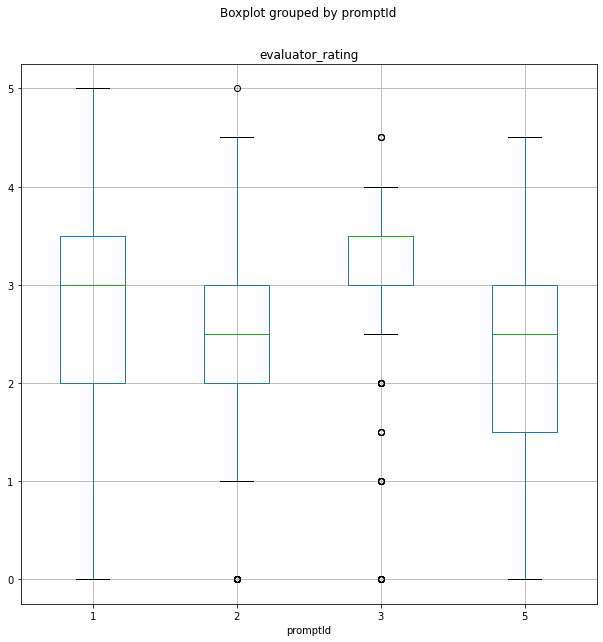

In [4]:
%matplotlib inline
dataframe.boxplot(column = 'evaluator_rating', by = 'promptId', figsize = (10, 10))

In [5]:
data = dataframe[['promptId','essay','evaluator_rating']].copy()
test = testframe[['promptId','essay']].copy()
print(data)

      promptId                                              essay  \
0            1  At present age, our education system is not go...   
1            1  I am agree the tightly defined curriculum of o...   
2            1  I strongly agree with the statement that tight...   
3            1  Our education system is nice quitely but i dis...   
4            1  i am totally agree with the statement that tig...   
...        ...                                                ...   
1235         5  The entire world is in the race of producing a...   
1236         5  The race in the development of weapons are pro...   
1237         5  In an era where every second person hopes and ...   
1238         5  INTRODUCTION :Since the beginning of the time ...   
1239         5  "To conquer a nation, first disarm its citizen...   

      evaluator_rating  
0                  3.0  
1                  4.0  
2                  2.0  
3                  2.0  
4                  3.0  
...                ..

In [6]:
# Tokenize a sentence into words

def sentence_to_wordlist(raw_sentence):
    
    clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
    tokens = nltk.word_tokenize(clean_sentence)
    
    return tokens

In [7]:
# tokenizing an essay into a list of word lists

def tokenize(essay):
    stripped_essay = essay.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            tokenized_sentences.append(sentence_to_wordlist(raw_sentence))
    
    return tokenized_sentences

In [8]:
# calculating average word length in an essay

def avg_word_len(essay):
    
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return sum(len(word) for word in words) / len(words)

In [9]:
# calculating number of words in an essay

def word_count(essay):
    
    clean_essay = re.sub(r'\W', ' ', essay)
    words = nltk.word_tokenize(clean_essay)
    
    return len(words)

In [10]:
# calculating number of characters in an essay

def char_count(essay):
    
    clean_essay = re.sub(r'\s', '', str(essay).lower())
    
    return len(clean_essay)

In [11]:
# calculating number of sentences in an essay

def sent_count(essay):
    
    sentences = nltk.sent_tokenize(essay)
    
    return len(sentences)

In [12]:
# calculating number of lemmas per essay

def count_lemmas(essay):
    
    tokenized_sentences = tokenize(essay)      
    
    lemmas = []
    wordnet_lemmatizer = WordNetLemmatizer()
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
        
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                pos = wordnet.ADJ
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                pos = wordnet.VERB
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                pos = wordnet.ADV
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(wordnet_lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return lemma_count

In [13]:
# checking number of misspelled words

def count_spell_error(essay):
    
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)
    
    #big.txt: It is a concatenation of public domain book excerpts from Project Gutenberg 
    #         and lists of most frequent words from Wiktionary and the British National Corpus.
    #         It contains about a million words.
    data = open('big.txt').read()
    test = open('big.txt').read()
    words_ = re.findall('[a-z]+', data.lower())
    
    word_dict = collections.defaultdict(lambda: 0)
                       
    for word in words_:
        word_dict[word] += 1
                       
    clean_essay = re.sub(r'\W', ' ', str(essay).lower())
    clean_essay = re.sub(r'[0-9]', '', clean_essay)
                        
    mispell_count = 0
    
    words = clean_essay.split()
                        
    for word in words:
        if not word in word_dict:
            mispell_count += 1
    
    return mispell_count

In [14]:
# calculating number of nouns, adjectives, verbs and adverbs in an essay

def count_pos(essay):
    
    tokenized_sentences = tokenize(essay)
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence)
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
        
            if pos_tag.startswith('N'): 
                noun_count += 1
            elif pos_tag.startswith('J'):
                adj_count += 1
            elif pos_tag.startswith('V'):
                verb_count += 1
            elif pos_tag.startswith('R'):
                adv_count += 1
            
    return noun_count, adj_count, verb_count, adv_count

In [15]:
# getiing Bag of Words (BOW) counts

def get_count_vectors(essays):
    
    vectorizer = CountVectorizer(max_features = 10000, ngram_range=(1, 3), stop_words='english')
    
    count_vectors = vectorizer.fit_transform(essays)
    
    feature_names = vectorizer.get_feature_names()
    
    return feature_names, count_vectors

In [16]:
# splitting data into train data and test data (70/30)

feature_names_cv, count_vectors = get_count_vectors(data['essay'])

feature_names_test, count_test = get_count_vectors(test['essay'])

test_set = count_test.toarray()

X_cv = count_vectors.toarray()

y_cv = data['evaluator_rating']

X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size = 0.3)

In [17]:
# Training a Linear Regression model using only Bag of Words (BOW)

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)
y_result = linear_regressor.predict(test_set)
# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))
print(y_result)
print(y_result.shape)

Coefficients: 
 [ 0.02284291 -0.03409029  0.01280176 ...  0.03318741  0.02458449
  0.00836212]
Mean squared error: 0.97
Variance score: 0.10
[1.75305515 1.67005045 1.67622927 1.166637   2.64164497 2.06038792
 1.41361639 1.7902736  1.366979   1.25256303 2.31805764 1.35296646
 1.38211439 1.29886181 1.78205421 1.84658685 1.59814968 2.08363742
 1.45169715 1.33558675 1.09333151 2.22912871 1.70348708 1.47798458
 1.24200081 1.31950944 2.04693568 1.52172598 1.57558662 1.6805305
 1.41077632 2.61791503 1.20102527 1.32861205 1.16080111 1.71460076
 1.68020893 2.58876775 1.03674452 1.27551947 2.3586705  1.16636532
 1.72021176 1.81146186 1.92661909 1.94266356 1.61379949 1.17659619
 1.746074   1.80811705 1.90206822 1.31256468 2.25379382 2.38869954
 1.89386357 1.7348393  1.48632462 1.45370575 2.17673808 1.53434073
 1.23434484 0.80931045 1.50611574 1.7825032  0.81991042 1.55044357
 1.49567681 1.29607885 1.5660233  2.5841546  2.36484298 1.51338816
 1.48559241 2.22436827 0.9591651  1.68922322 1.77459072 

In [18]:
# extracting essay features

def extract_features(data):
    
    features = data.copy()
    
    features['char_count'] = features['essay'].apply(char_count)
    
    features['word_count'] = features['essay'].apply(word_count)
    
    features['sent_count'] = features['essay'].apply(sent_count)
    
    features['avg_word_len'] = features['essay'].apply(avg_word_len)
    
    features['lemma_count'] = features['essay'].apply(count_lemmas)
    
    features['spell_err_count'] = features['essay'].apply(count_spell_error)
    
    features['noun_count'], features['adj_count'], features['verb_count'], features['adv_count'] = zip(*features['essay'].map(count_pos))
    
    return features

In [19]:
# extracting features from essay set 1

features_set1 = extract_features(data)

print(features_set1)

features_set2 = extract_features(test)

print(features_set2)

      promptId                                              essay  \
0            1  At present age, our education system is not go...   
1            1  I am agree the tightly defined curriculum of o...   
2            1  I strongly agree with the statement that tight...   
3            1  Our education system is nice quitely but i dis...   
4            1  i am totally agree with the statement that tig...   
...        ...                                                ...   
1235         5  The entire world is in the race of producing a...   
1236         5  The race in the development of weapons are pro...   
1237         5  In an era where every second person hopes and ...   
1238         5  INTRODUCTION :Since the beginning of the time ...   
1239         5  "To conquer a nation, first disarm its citizen...   

      evaluator_rating  char_count  word_count  sent_count  avg_word_len  \
0                  3.0        1406         306          12      4.535948   
1                  

<AxesSubplot:xlabel='adv_count', ylabel='evaluator_rating'>

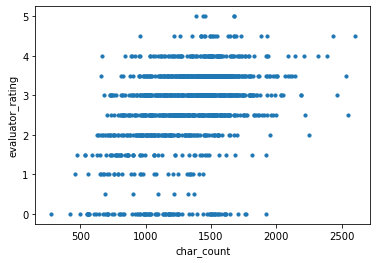

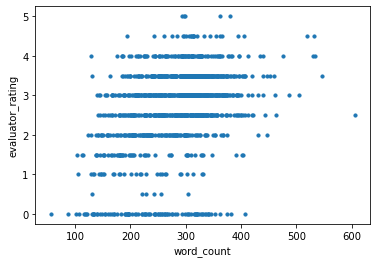

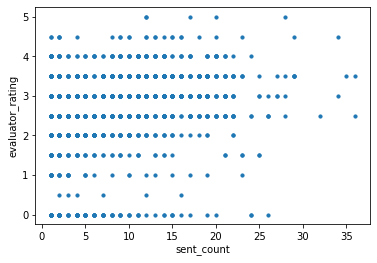

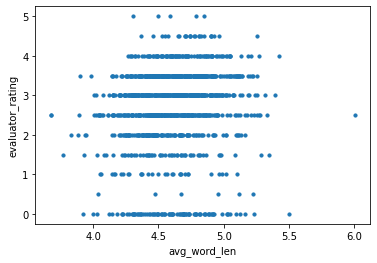

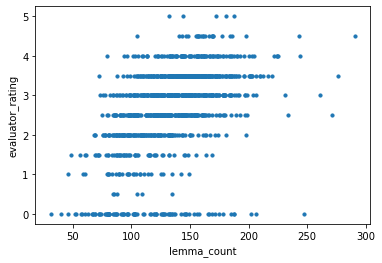

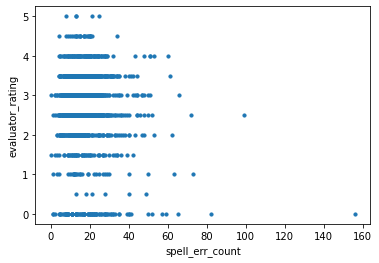

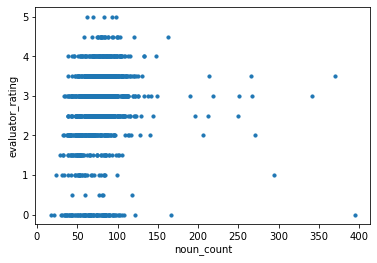

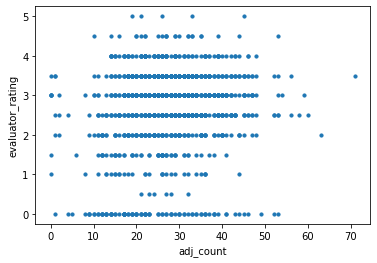

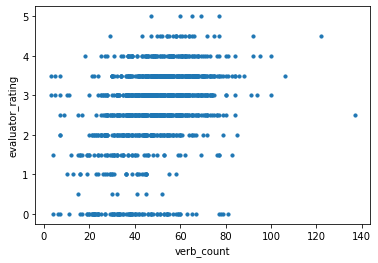

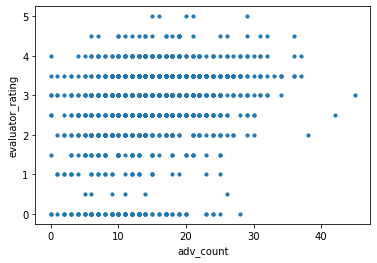

In [20]:
# Exploratory Data Analysis (EDA) on the data

%matplotlib inline
features_set1.plot.scatter(x = 'char_count', y = 'evaluator_rating', s=10)
features_set1.plot.scatter(x = 'word_count', y = 'evaluator_rating', s=10)
features_set1.plot.scatter(x = 'sent_count', y = 'evaluator_rating', s=10)
features_set1.plot.scatter(x = 'avg_word_len', y = 'evaluator_rating', s=10)
features_set1.plot.scatter(x = 'lemma_count', y = 'evaluator_rating', s=10)
features_set1.plot.scatter(x = 'spell_err_count', y = 'evaluator_rating', s=10)
features_set1.plot.scatter(x = 'noun_count', y = 'evaluator_rating', s=10)
features_set1.plot.scatter(x = 'adj_count', y = 'evaluator_rating', s=10)
features_set1.plot.scatter(x = 'verb_count', y = 'evaluator_rating', s=10)
features_set1.plot.scatter(x = 'adv_count', y = 'evaluator_rating', s=10)

# Essay Set 1 Trends:

# By plotting the below scatter plots, we can examine how different features above affect the grade the student receives.

# 1. I observed that there is a strong correlation between character count of an essay and the final essay score. 
#    I observed similar correlations for word count, sentence count and lemma count of an essay.
#    These features indicate language fluency and dexterity.
# 2. Various parts-of-speech such as nouns, adjectives adverbs and verbs are good proxies to test vocabulary. 
#    This feature can also be taken as a rudimentary proxy for diction.
#    I observed a strong correlation between noun_count and the final essay score. Sililar trends were observed for verb count,
#    adjective count and adverb count of an essay.
# 3. I did not observe any significant correlation between average word length of an essay and its score.
# 4. There is a weaker correlation between the number of spelling errors and the final score of an essay.

In [21]:
# splitting data (BOW + other features) into train data and test data (70/30)
print(X_train.shape)
print(test_set.shape)
X = np.concatenate((features_set1.iloc[:, 3:], X_cv), axis = 1)
y = features_set1['evaluator_rating']
print(X_cv)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

(868, 10000)
(305, 10000)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [22]:
print(X_train.shape)
print(test_set.shape)
test_set = np.concatenate((features_set2.iloc[:, 2:], test_set), axis = 1)
print(test_set.shape)

(868, 10010)
(305, 10000)
(305, 10010)


In [23]:
linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

y_result = linear_regressor.predict(test_set)
# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

Coefficients: 
 [ 0.00129835 -0.0038858   0.01320749 ...  0.0007109   0.03124615
  0.00297332]
Mean squared error: 0.99
Variance score: 0.18


In [24]:
# Training a Ridge Regression model (l2 regularization) using all the features (BOW + other features)

alphas = np.array([3, 1, 0.3, 0.1])

ridge_regressor = Ridge()

grid = GridSearchCV(estimator = ridge_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_result = grid.predict(test_set)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

0.11796584835223242
3.0
Mean squared error: 0.97
Variance score: 0.20


In [25]:
# Training a Lasso Regression model (l1 regularization) using all the features (BOW + other features)

alphas = np.array([3, 1, 0.3, 0.1])

lasso_regressor = Lasso()

grid = GridSearchCV(estimator = lasso_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)
y_result = grid.predict(test_set)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))
print(y_result)
print(y_result.shape)
print(test_set.shape)

0.3017906515024832
0.1
Mean squared error: 0.76
Variance score: 0.38
[2.60051174 2.93638954 2.05201374 2.35851531 2.63527833 2.38566704
 2.75319608 2.92134631 2.34253505 2.51757211 2.4451487  2.75927973
 2.68767629 2.64251244 3.22133    2.34896261 2.86076308 2.23684181
 3.02379254 2.75740096 2.82788901 2.95645556 2.43840759 2.38855535
 2.73213566 3.01218919 2.78920228 2.82972591 3.00007092 2.75513308
 2.38790466 2.83503644 2.40800831 3.2598698  2.1193309  2.97981229
 2.64205878 2.82280956 2.9950626  2.91031089 2.45038983 2.86863054
 3.07053045 2.8837231  2.3860309  3.28248252 3.03971929 3.20654052
 2.54176307 2.95583885 2.68143782 3.10538245 3.24509074 2.53755606
 2.23783194 1.92112948 2.90306261 2.2055424  3.05635597 2.46208881
 2.52410394 2.83756455 2.45114927 3.37570935 2.56225671 2.39542503
 1.43264276 1.91242099 4.33753186 2.51595952 2.47239606 2.51403116
 2.6475642  2.39377984 1.60008645 2.1255595  3.76434293 3.32817506
 2.88931567 2.16238368 3.05095023 3.25669935 1.43085336 2.95

In [26]:
# splitting data (only 10 numerical/POS/orthographic features) into train data and test data (70/30)
    
X = features_set1.iloc[:, 3:]

y = features_set1['evaluator_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [27]:
print(X_train)

      char_count  word_count  sent_count  avg_word_len  lemma_count  \
765          997         225           1      4.302222          107   
426          879         202           5      4.252475          124   
236         1475         323          20      4.476780          181   
1066        1131         249           3      4.453815          140   
933          807         175          15      4.514286           85   
...          ...         ...         ...           ...          ...   
859         1271         291          13      4.261168          159   
308         1462         324          21      4.432099          157   
51          1673         333          12      4.963964          177   
802         1059         228           4      4.526316          123   
140         1393         299          10      4.602007          142   

      spell_err_count  noun_count  adj_count  verb_count  adv_count  
765                12          62         24          38          8  
426    

In [28]:
# Training a Linear Regression model using only 10 numerical/POS/orthographic features

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))


Coefficients: 
 [ 0.00083565 -0.00290329  0.00590794  0.27533913  0.01550506 -0.0233375
 -0.00225273 -0.01319898  0.00372718  0.00958619]
Mean squared error: 0.80
Variance score: 0.33


In [29]:
# Training a Ridge Regression model (l2 regularization) using only 10 numerical/POS/orthographic features

alphas = np.array([3, 1, 0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001])

ridge_regressor = Ridge()

grid = GridSearchCV(estimator = ridge_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

0.2812333820288241
3.0
Mean squared error: 0.80
Variance score: 0.33


In [30]:
# Training a Lasso Regression model (l1 regularization) using only 10 numerical/POS/orthographic features

alphas = np.array([3, 1, 0.3, 0.1, 0.3])

lasso_regressor = Lasso()

grid = GridSearchCV(estimator = lasso_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

0.2850953766850258
0.1
Mean squared error: 0.80
Variance score: 0.33


0.28765679685381007
GradientBoostingRegressor(learning_rate=0.01, max_depth=2, n_estimators=500)
MSE: 0.7522
Variance score: 0.37



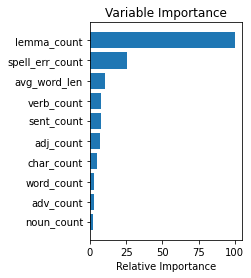

In [31]:
# Training a Gradient Boosting Regression model using only 10 numerical/POS/orthographic features

params = {'n_estimators':[50, 100, 500, 1000], 'max_depth':[2], 'min_samples_split': [2],
          'learning_rate':[1, 0.1, 0.3, 0.01], 'loss': ['ls']}

gbr = ensemble.GradientBoostingRegressor()

grid = GridSearchCV(gbr, params)
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

mse = mean_squared_error(y_test, y_pred)
print("MSE: %.4f" % mse)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))
print()


# Plot feature importance - to find the main factors affecting the final grade
feature_importance = grid.best_estimator_.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_names = list(features_set1.iloc[:, 3:].columns.values)
feature_names = np.asarray(feature_names)
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [32]:

y_result = pd.DataFrame(y_result)
y_result.columns = ['evaluator_rating']
y_result = y_result.round({'evaluator_rating':0})
print(test.shape)
test['evaluator_rating'] = y_result
print(test.shape)
test.to_csv('test_prediction.csv')

(305, 2)
(305, 3)


In [33]:
# Observations:
    
# 1. Using only BOW features:
#     Lasso Regression performs better than linear regression.

# 2. Using all features:
#     Lasso Regression performs much better than Linear Regression and Ridge Regression.
#     Gradient Boosting Regression performs better i.e. has a higher variance score and kappa score than all of the above.

# 3. Using only numerical/POS/orthographic features:
#     Support Vector Regression performs the worst among all other models.
#     Linear, Ridge and Lasso Regression have a similar performance.
#     Gradient Boosting Regression has the highest variance and kappa scores.

# Hence, we can observe that models trained with all the features (BOW + numerical/POS/orthographic features) and 
# models trained only with 10 numerical/POS/orthographic features produce similar scores.

# More features such as tf-idf scores, punctuation counts, essay sentiment, essay prompt etc can be added to improve 
# accuracy of prediction.